# Demo for generating substrates and running a single simulation
This notebook is intended as a demo that reproduces a single simulation with generic parameters for the substrate geometry and the sequence applied. Readers are free to alter the parameters and use this as a base example for their own explorations. For a more general introduction to MCMRSimulator, see [its dedicated tutorial](https://open.win.ox.ac.uk/pages/ndcn0236/mcmrsimulator.jl/v0.9/tutorial_julia/).

## Set up environment and import packages

In [2]:
using Pkg
# Activate the specific environment with the correct packages and version 
Pkg.activate(".")
Pkg.instantiate()
# Import packages
using MCMRSimulator
using CairoMakie
using Statistics
using DelimitedFiles
using FileIO
using Printf
using JLD2

  Activating project at `~/Library/CloudStorage/OneDrive-Nexus365/SWI&DTI/Papers/2024 MRM/gitrepo/MT-and-permeability-effect-on-two-compartment-dMRI-WM-model`


## Create substrates
Generically, the base MCMRSimulator has a built-in function `random_positions_radii()` for generating positions and radius values for a given volume density value and radius distribution (Gamma distribution characterised by mean and variance). However, at v0.9.0 this function generated cylinder packing configurations that are highly inhomogeneous, which resulted in clusters of cylinders and large gaps between clusters. This affected the consistency and accuracy of our simulated signal. Thus, two custom functions, `repel_fixed_radius()` and `repel_distributed_radius()` were created to take the output of `random_positions_radii()` and add repulsions between cylinders to create a more homogeneous packing configuration. These have since been integrated into the new versions of base MCMRSimulator but for consistency with our results in paper we kept them here.  

In [5]:
# import functions
include("repel_cylinders.jl")

# Set various parameters for the substrate
T2 = 100                          # effective T2 caused by MT (ms)
rho = 0.65                        # cylinder volume density
r = 1                             # cylinder radius (μm)
rep = r*100                       # (half of) the distance over which the substrate repeats itself spatially

# Set MT (surface relaxivity) and permeability
T2_bound = 1e-3                   # Bound pool T2 to model surface relaxivity (ms)
t_dwell = 30                      # Dwell time of isochromats in the bound pool, controls the strength of surface relaxivity
svratio = 2/r                     # Calculate the surface to volume ratio that is used to calculate the surface density later
surf_dens = 1/svratio*t_dwell/T2  # Surface density of isochromats that achieves the given T2, it's the ratio of isochromat density on the substrate (cylinder) and isochromat density in the volume of interest
perm = 0.005                      # permeability, probability for an isochromat to pass through the cylinder wall when they encounter

# Create a substrate with parallel cylinders of fixed diameters 
res = MCMRSimulator.random_positions_radii([rep*1.001, rep*1.001], rho*1.001^2, 2, mean=r*1.001, variance=0)                                                     # generate cylinder center positions based on slightly larger radius to avoid overlapping
repeled = repel_fixed_radius(r*1.001, res[1], rep*1.001, maxiter=1000, repulsion_strength=3e-3)                                                                  # use the custom function to refine the packing configuration and make it more homogeneous
fixed_d_cyl = Cylinders(position=repeled, radius=r, dwell_time=t_dwell, density=surf_dens, permeability=perm, repeats=[rep, rep], R2_surface=1/T2_bound)         # create the cylinders object with refined positions
MCMRSimulator.write_geometry(".cylinders_MT_"* string(T2) *"_sus_0_perm_"*@sprintf("%.3f",perm)*"_rmean_"*@sprintf("%.2f",r)*"_density_0.65.json", fixed_d_cyl)  # it's possible to save the object as a .json file to be read by MCMRSimulator later 


There are 2074 Cylinder based on values for Field(position)


Similarly, we can also create substrates containing parallel cylinders with Gamma-distributed diameters, note this may take a bit longer than the fixed diameter case.

In [ ]:
# import functions
include("repel_cylinders.jl")

# Set various parameters for the substrate
T2 = 100                          # effective T2 caused by MT (ms)
rho = 0.65                        # cylinder volume density
r = 1                             # mean cylinder radius (μm)
r_var = 1                         # variance of cylinder radius (μm^2)
rep = r*100                       # (half of) the distance over which the substrate repeats itself spatially

# Set MT (surface relaxivity) and permeability
T2_bound = 1e-3                   # Bound pool T2 to model surface relaxivity (ms)
t_dwell = 30                      # Dwell time of isochromats in the bound pool, controls the strength of surface relaxivity
svratio = 2/r                     # Calculate the surface to volume ratio that is used to calculate the surface density later
surf_dens = 1/svratio*t_dwell/T2  # Surface density of isochromats that achieves the given T2, it's the ratio of isochromat density on the substrate (cylinder) and isochromat density in the volume of interest
perm = 0.005                      # permeability, probability for an isochromat to pass through the cylinder wall when they encounter

# Create a substrate with parallel cylinders of distributed diameters 
res = MCMRSimulator.random_positions_radii([rep, rep], rho, 2, mean=r, variance=1)                                                                               # generate cylinder center positions and radii following the mean and variance
repeled = repel_distributed_radius(res[2], res[1], rep, maxiter=1000, repulsion_strength=1e-2)                                                                   # use the custom function to refine the packing configuration and make it more homogeneous
distr_d_cyl = Cylinders(position=repeled, radius=r, dwell_time=t_dwell, density=surf_dens, permeability=perm, repeats=[rep, rep], R2_surface=1/T2_bound)         # create the cylinders object with refined positions
MCMRSimulator.write_geometry(".cylinders_MT_"* string(T2) *"_sus_0_perm_"*@sprintf("%.3f",perm)*"_rmean_"*@sprintf("%.2f",r)*"_density_0.65.json", distr_d_cyl)  # it's possible to save the object as a .json file to be read by MCMRSimulator later 


It is possible to plot the geometry to visually check it

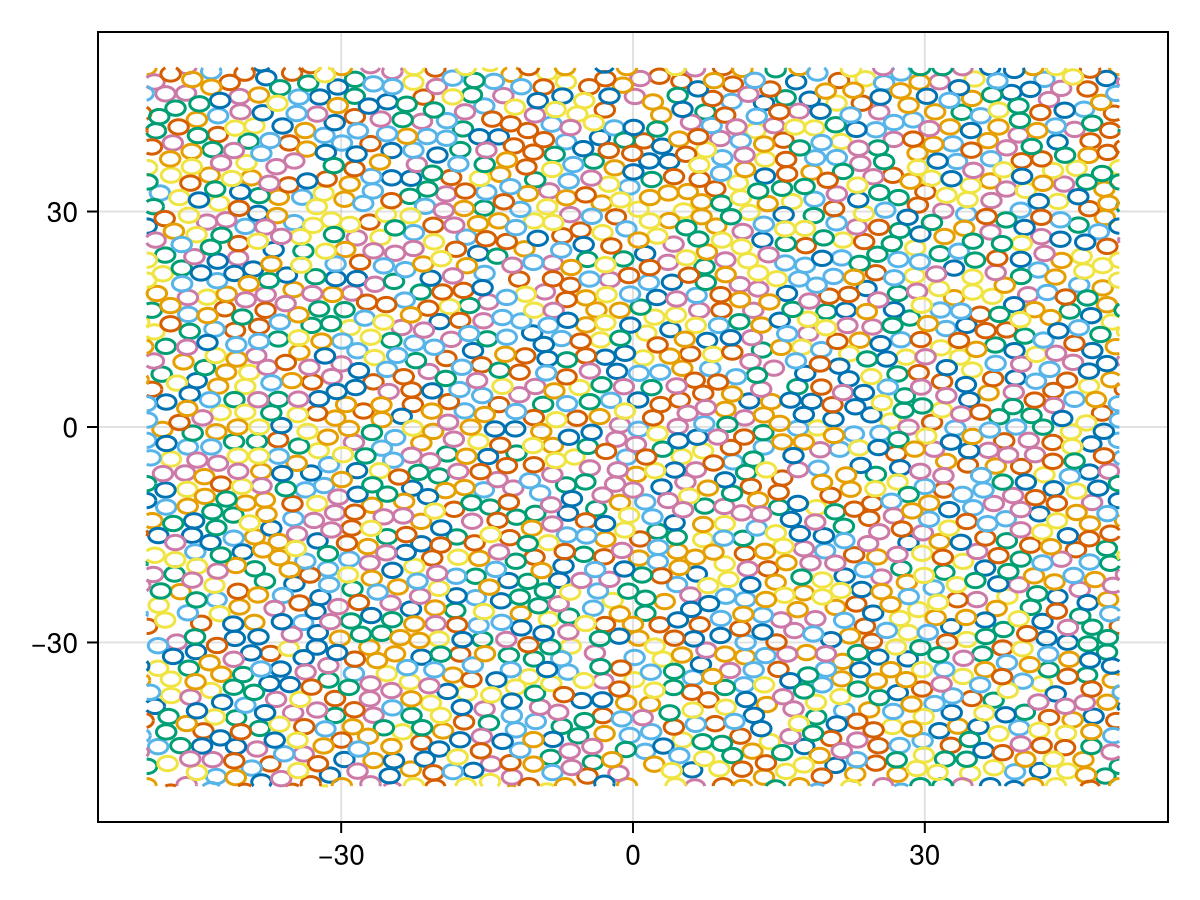

In [6]:
f = plot(PlotPlane(size=100), fixed_d_cyl)

## Create diffusion-weighted spin-echo sequence
This step just uses built-in function `dwi()` of MCMRSimulator. It allows the user to set many parameters of the DWSE sequence. In our case, gradient_duration, gradient_strength, diffusion_time, TE, and TR were set. For a more detailed explanation and general use of the function, check the [MCMRSimulator tutorial](https://open.win.ox.ac.uk/pages/ndcn0236/mcmrsimulator.jl/v0.9/sequence/#sequence). Note in the later versions of MCMRSimulator, a new package `MRIBuilder` was created for building generic sequences using optimisation tools. See [its documentation](https://open.win.ox.ac.uk/pages/ndcn0236/mribuilder.jl/dev/) for more details.

In [7]:
# Set sequence parameters
TR=3000                 # ms
TE=166                  # ms
delta=2.5               # gradient duration (ms)
g=1200                  # gradient strength (mT/m)
gamma=0.00004257638476  # gyromagnetic ratio for proton (kHz/mT ̇1e-6), needed as dwi() takes gradient strength with kHz/μm unit
Delta=20                # diffusion time (ms)

# Create the sequence using dwi()
seq = dwi(gradient_duration=delta, gradient_strength=g*gamma, diffusion_time=Delta, TE=TE, TR=TR)

Sequence (TR=3000.0ms):
    - InstantRFPulse: t=0.0ms, θ=90.0°, ϕ=-90.0°;
    - InstantRFPulse: t=83.0ms, θ=180.0°, ϕ=0.0°;
    - Readout at 166.0ms
    - InstantGradient: t=166.000001ms, q=[0.5773502691896258, 0.5773502691896258, 0.5773502691896258]rad/um;


## Run the simulation and generate signal
Now we have both the substrate and sequence, we can run the simulation by calling the `Simulation()` constructor and get a readout of the final signal level using the `readout()` function. For more details about `readout()`, check the [MCMRSimulator tutorial](https://open.win.ox.ac.uk/pages/ndcn0236/mcmrsimulator.jl/v0.9/tutorial_julia/#Simple-signal-readouts).

In [10]:
# Construct the simulation object with Simulation() and our sequence (seq) and substrate (fixed_d_cyl) objects as inputs, diffusivity value can be changed depending on the substrate
d = 2.3     # intrinsic diffusivity (μm^2/ms)
sim = Simulation(seq, diffusivity=d, geometry=fixed_d_cyl) # fixed_d_cyl can be replaced by distr_d_cyl

# Use readout() to obtain the signal level given a certain number of isochromats, the bounding box defines the region of interest, an appropriate size is set to be relevant to the repetition scale of the substrate (rep) without including too many cylinders and significantly slowing down the simulation. The subset argument allows us to obtain signals from different parts of the substrate geometry (inside cylinders, outside cylinders, total signal).
sz = rep*2                                    # Scale of bounding box (i.e. volume of interest), here the volume is cubic so only one number is needed to characterise it.
bbox = BoundingBox([-sz,-sz,-sz],[sz,sz,sz])  # Create the bounding box (cuboid) by setting its lower and upper vertices along the diagonal.
n_isochromat = 1000                           # number of isochromats, larger number can lead to lower noise floor level but will slow down the simulation
sig = readout(n_isochromat, sim, bounding_box=bbox, subset=[Subset(inside=true), Subset(inside=false), Subset()])

# The output signal can be written to a csv file and analysed later in python or other language/software, note transverse() is applied to the simulated signal as we can only read the transverse signal in reality.
writedlm(".signal_MT_"*@sprintf("%d",T2)*"_sus_0_perm_"*@sprintf("%.3f",perm)*"_rmean_"*@sprintf("%.2f",r)*"_density_0.65.csv", transverse.(sig), ',')